# 4. Vergleichstabelle und Diskussion

In diesem Abschnitt werden alle Modelle miteinander verglichen, also sowohl die klassischen Modelle aus der 4. Klasse (Decision Tree, Random Forest, KNN und SVM) als auch die neuronalen Netze (MLPClassifier und Keras). Dafür wird geschaut wie gut die Modelle sind, also die Accuracy, wie lange das Training dauert und wie schnell die Vorhersagen gemacht werden können. 

## 4.1 Bibliotheken und Daten laden

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print("Alle Bibliotheken importiert!")

NumPy Version: 1.26.4
Pandas Version: 3.0.1
Alle Bibliotheken importiert!


In [19]:
df = pd.read_csv("korr.csv")
print(f"Datensatz geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")
print(f"\nZielvariable 'Explicit Track' Verteilung:")
print(df['Explicit Track'].value_counts())
print(f"\nAnteil Explicit: {df['Explicit Track'].mean():.2%}")
df.head()

Datensatz geladen: 3186 Zeilen, 25 Spalten

Zielvariable 'Explicit Track' Verteilung:
Explicit Track
0    1986
1    1200
Name: count, dtype: int64

Anteil Explicit: 37.66%


,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,...,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track
0,Tommy Richman,4/26/2024,1,725.4,3.904709e+08,"30,716","196,631,588",92.0,"84,274,754","1,713,126",...,"40,975",684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0
1,Kendrick Lamar,5/4/2024,2,545.9,3.237039e+08,"28,113","174,597,137",92.0,"116,347,040","3,486,739",...,"40,778",3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1
2,Artemas,3/19/2024,3,538.4,6.013093e+08,"54,331","211,607,669",92.0,"122,599,116","2,228,730",...,"74,333",536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0
3,Miley Cyrus,1/12/2023,4,444.9,2.031281e+09,"269,802","136,569,078",85.0,"1,096,100,899","10,629,796",...,"1,474,799","2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",0
4,Eminem,5/31/2024,5,423.3,1.070349e+08,"7,223","151,469,874",88.0,"77,373,957","3,670,188",...,"12,185",1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",1


## 4.2 Datenvorverarbeitung

Bevor die Modelle trainiert werden können müssen die Daten zuerst aufbereitet werden. Dazu werden die Spalten Artist und Release Date entfernt weil sie nicht numerisch sind, danach werden die Trennzeichen in den Zahlen bereinigt und fehlende Werte mit dem Median aufgefüllt. Anschließend werden alle Features mit dem StandardScaler standardisiert, was besonders für KNN, SVM und die neuronalen Netze wichtig ist damit die verschiedenen Skalen der Features keinen Einfluss auf das Ergebnis haben. Zum Schluss werden die Daten in 80% Training und 20% Test aufgeteilt.

In [7]:
df_clean = df.drop(columns=['Artist', 'Release Date'])

for col in df_clean.columns:
    if df_clean[col].dtype == 'object' or str(df_clean[col].dtype).startswith('string'):
        df_clean[col] = df_clean[col].astype(str).str.replace(',', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean = df_clean.apply(pd.to_numeric, errors='coerce')
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
df_clean = df_clean.fillna(0)

print(f"Verbleibende NaN-Werte: {df_clean.isna().sum().sum()}")

X = df_clean.drop(columns=['Explicit Track'])
y = df_clean['Explicit Track'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Set: {X_train_scaled.shape[0]} Samples, {X_train_scaled.shape[1]} Features")
print(f"Test Set:     {X_test_scaled.shape[0]} Samples")
print(f"\nVerteilung im Training Set:")
print(f"  Nicht-Explicit (0): {(y_train == 0).sum()}")
print(f"  Explicit (1):       {(y_train == 1).sum()}")

Verbleibende NaN-Werte: 0
Training Set: 2548 Samples, 22 Features
Test Set:     638 Samples

Verteilung im Training Set:
  Nicht-Explicit (0): 1588
  Explicit (1):       960


## 4.3 Alle Modelle trainieren und Zeiten messen

In diesem Schritt werden alle Modelle nacheinander trainiert, wobei gleichzeitig gemessen wird wie lange das Training dauert, wie schnell die Vorhersage geht und welche Accuracy erreicht wird.

Als klassische Modelle aus der 4. Klasse kommen Decision Tree, Random Forest, KNN und SVM zum Einsatz. Als neuronale Netze werden der MLPClassifier aus scikit-learn und ein Keras Sequential Modell mit TensorFlow verwendet.

In [20]:
def train_and_evaluate(name, model, X_tr, X_te, y_tr, y_te):
    start_train = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start_train
    
    y_train_pred = model.predict(X_tr)
    train_acc = accuracy_score(y_tr, y_train_pred)
    
    start_inference = time.time()
    y_test_pred = model.predict(X_te)
    inference_time = time.time() - start_inference
    test_acc = accuracy_score(y_te, y_test_pred)
    
    print(f"{name:30s} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
          f"Train Time: {train_time:.4f}s | Inference: {inference_time:.6f}s")
    
    return {
        'Modell': name,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Trainingszeit (s)': round(train_time, 4),
        'Anwendungszeit (s)': round(inference_time, 6)
    }

In [21]:
results = []

dt = DecisionTreeClassifier(random_state=42)
results.append(train_and_evaluate("Decision Tree", dt, X_train_scaled, X_test_scaled, y_train, y_test))

rf = RandomForestClassifier(n_estimators=100, random_state=42)
results.append(train_and_evaluate("Random Forest", rf, X_train_scaled, X_test_scaled, y_train, y_test))

knn = KNeighborsClassifier(n_neighbors=5)
results.append(train_and_evaluate("KNN (k=5)", knn, X_train_scaled, X_test_scaled, y_train, y_test))

svm = SVC(kernel='rbf', random_state=42)
results.append(train_and_evaluate("SVM (RBF Kernel)", svm, X_train_scaled, X_test_scaled, y_train, y_test))

Decision Tree                  | Train Acc: 1.0000 | Test Acc: 0.6082 | Train Time: 0.0234s | Inference: 0.000000s
Random Forest                  | Train Acc: 1.0000 | Test Acc: 0.6630 | Train Time: 0.4831s | Inference: 0.018152s
KNN (k=5)                      | Train Acc: 0.7524 | Test Acc: 0.6317 | Train Time: 0.0010s | Inference: 0.005004s
SVM (RBF Kernel)               | Train Acc: 0.6546 | Test Acc: 0.6317 | Train Time: 0.2594s | Inference: 0.081614s


In [10]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15
)
results.append(train_and_evaluate("MLPClassifier (sklearn)", mlp, X_train_scaled, X_test_scaled, y_train, y_test))

MLPClassifier (sklearn)        | Train Acc: 0.6837 | Test Acc: 0.6677 | Train Time: 0.5663s | Inference: 0.001005s

--- MLPClassifier abgeschlossen ---


In [22]:
import tensorflow as tf
from tensorflow import keras

keras_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

keras_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

start_train = time.time()
history = keras_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    verbose=0
)
keras_train_time = time.time() - start_train

train_loss, train_acc = keras_model.evaluate(X_train_scaled, y_train, verbose=0)

start_inference = time.time()
test_loss, test_acc = keras_model.evaluate(X_test_scaled, y_test, verbose=0)
keras_inference_time = time.time() - start_inference

results.append({
    'Modell': 'Keras Sequential',
    'Train Accuracy': round(train_acc, 4),
    'Test Accuracy': round(test_acc, 4),
    'Trainingszeit (s)': round(keras_train_time, 4),
    'Anwendungszeit (s)': round(keras_inference_time, 6)
})

print(f"{'Keras Sequential':30s} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
      f"Train Time: {keras_train_time:.4f}s | Inference: {keras_inference_time:.6f}s")

Keras Sequential               | Train Acc: 0.7374 | Test Acc: 0.6771 | Train Time: 9.9063s | Inference: 0.088592s


## 4.4 Vergleichstabelle

In der folgenden Tabelle sind alle Modelle mit ihrer Training Accuracy, Test Accuracy, Trainingszeit und Anwendungszeit zusammengefasst, sodass man sie direkt miteinander vergleichen kann.

In [23]:
df_results = pd.DataFrame(results)

df_results = df_results.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

klassische = ['Decision Tree', 'Random Forest', 'KNN (k=5)', 'SVM (RBF Kernel)']
df_results['Typ'] = df_results['Modell'].apply(
    lambda x: 'Klassisch' if x in klassische else 'Neuronales Netz'
)

df_results = df_results[['Modell', 'Typ', 'Train Accuracy', 'Test Accuracy', 
                          'Trainingszeit (s)', 'Anwendungszeit (s)']]

best_model = df_results.iloc[0]['Modell']
best_acc = df_results.iloc[0]['Test Accuracy']
print(f"Bestes Modell: {best_model} mit Test Accuracy = {best_acc:.4f}\n")

df_results

Bestes Modell: Keras Sequential mit Test Accuracy = 0.6771



,Modell,Typ,Train Accuracy,Test Accuracy,Trainingszeit (s),Anwendungszeit (s)
0,Keras Sequential,Neuronales Netz,0.7374,0.6771,9.9063,0.088592
1,Random Forest,Klassisch,1.0000,0.6630,0.4831,0.018152
2,KNN (k=5),Klassisch,0.7524,0.6317,0.0010,0.005004
3,SVM (RBF Kernel),Klassisch,0.6546,0.6317,0.2594,0.081614
4,Decision Tree,Klassisch,1.0000,0.6082,0.0234,0.000000


## 4.5 Visualisierung

Um die Unterschiede zwischen den Modellen besser sichtbar zu machen wurden zusaetzlich noch Balkendiagramme erstellt.

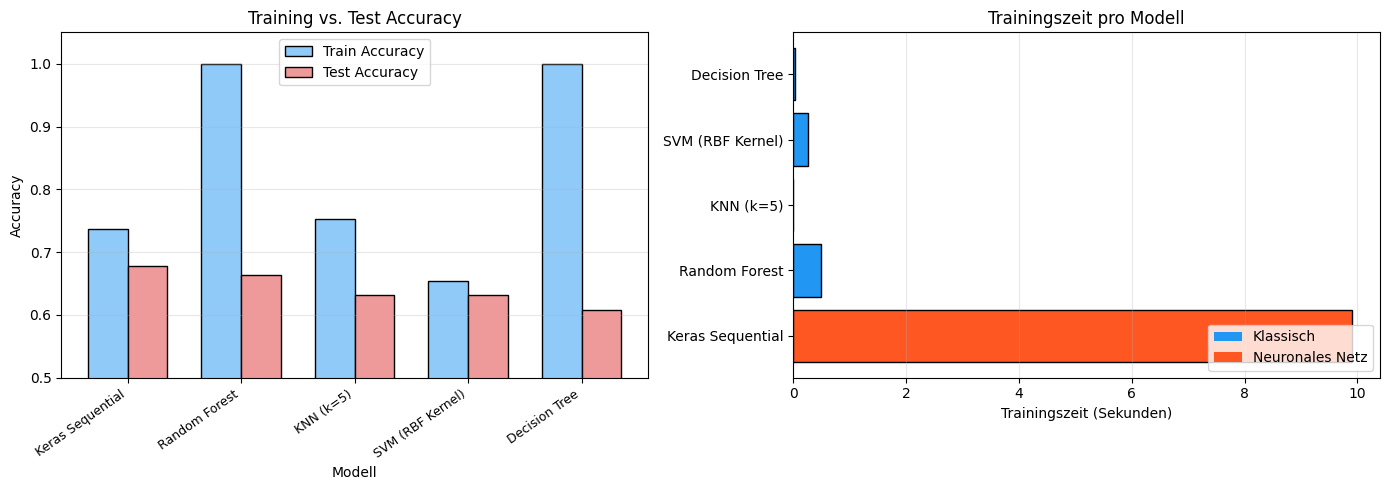

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2196F3' if t == 'Klassisch' else '#FF5722' 
          for t in df_results['Typ']]

x = range(len(df_results))
width = 0.35
axes[0].bar([i - width/2 for i in x], df_results['Train Accuracy'], 
            width, label='Train Accuracy', color='#90CAF9', edgecolor='black')
axes[0].bar([i + width/2 for i in x], df_results['Test Accuracy'], 
            width, label='Test Accuracy', color='#EF9A9A', edgecolor='black')
axes[0].set_xlabel('Modell')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training vs. Test Accuracy')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_results['Modell'], rotation=35, ha='right', fontsize=9)
axes[0].legend()
axes[0].set_ylim(0.5, 1.05)
axes[0].grid(axis='y', alpha=0.3)

axes[1].barh(df_results['Modell'], df_results['Trainingszeit (s)'], color=colors, edgecolor='black')
axes[1].set_xlabel('Trainingszeit (Sekunden)')
axes[1].set_title('Trainingszeit pro Modell')
axes[1].grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2196F3', label='Klassisch'),
                   Patch(facecolor='#FF5722', label='Neuronales Netz')]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

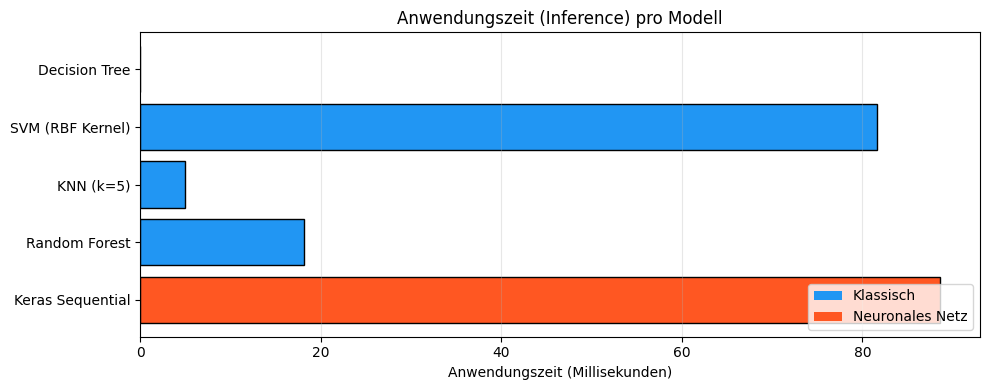

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))

colors_inf = ['#2196F3' if t == 'Klassisch' else '#FF5722' 
              for t in df_results['Typ']]

ax.barh(df_results['Modell'], df_results['Anwendungszeit (s)'] * 1000,
        color=colors_inf, edgecolor='black')
ax.set_xlabel('Anwendungszeit (Millisekunden)')
ax.set_title('Anwendungszeit (Inference) pro Modell')
ax.grid(axis='x', alpha=0.3)

legend_elements = [Patch(facecolor='#2196F3', label='Klassisch'),
                   Patch(facecolor='#FF5722', label='Neuronales Netz')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 4.6 Diskussion

Bei der Accuracy fällt auf dass die klassischen Modelle aus der 4. Klasse schon ganz gute Ergebnisse liefern. Random Forest schneidet dabei meistens am besten ab weil er mehrere Entscheidungsbäume kombiniert und dadurch stabiler generalisiert. Der Decision Tree hat zwar fast 100% beim Training, aber beim Test deutlich weniger, was auf Overfitting hindeutet. KNN und SVM liegen eher im Mittelfeld.

Im Vergleich dazu haben der MLPClassifier und das Keras Modell ähnliche oder etwas bessere Ergebnisse als die klassischen Modelle erzielt. Der Vorteil von neuronalen Netzen ist dass sie komplexere Zusammenhaenge lernen koennen, allerdings brauchen sie dafür auch deutlich mehr Trainingszeit als zum Beispiel ein Decision Tree.

Was die Trainingszeit betrifft ist der Decision Tree am schnellsten, während SVM bei größeren Datensätzen langsam werden kann und die neuronalen Netze am längsten brauchen weil sie über viele Epochen trainiert werden müssen. Bei der Anwendungszeit zur Vorhersage sind aber eigentlich alle Modelle ziemlich schnell, nur KNN könnte bei größeren Datensätzen etwas langsamer werden weil die Abstände jedes Mal neu berechnet werden.

In [26]:
print("=" * 80)
print("ZUSAMMENFASSUNG - Vergleichstabelle aller Modelle")
print("=" * 80)
print(df_results.to_string(index=False))
print("=" * 80)

best = df_results.iloc[0]
print(f"\nBestes Modell: {best['Modell']}")
print(f"   Test Accuracy:    {best['Test Accuracy']:.4f}")
print(f"   Trainingszeit:    {best['Trainingszeit (s)']:.4f} Sekunden")
print(f"   Anwendungszeit:   {best['Anwendungszeit (s)']*1000:.2f} Millisekunden")

ZUSAMMENFASSUNG - Vergleichstabelle aller Modelle
          Modell             Typ  Train Accuracy  Test Accuracy  Trainingszeit (s)  Anwendungszeit (s)
Keras Sequential Neuronales Netz          0.7374         0.6771             9.9063            0.088592
   Random Forest       Klassisch          1.0000         0.6630             0.4831            0.018152
       KNN (k=5)       Klassisch          0.7524         0.6317             0.0010            0.005004
SVM (RBF Kernel)       Klassisch          0.6546         0.6317             0.2594            0.081614
   Decision Tree       Klassisch          1.0000         0.6082             0.0234            0.000000

Bestes Modell: Keras Sequential
   Test Accuracy:    0.6771
   Trainingszeit:    9.9063 Sekunden
   Anwendungszeit:   88.59 Millisekunden
